In [57]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 

# Machine Learning libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import scipy as sp
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.offline as py
py.init_notebook_mode()

# MLTOOLS - Custom library
from mltools import regression_tools as RT
from mltools import forecast_tools as FT
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns

# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st
from datetime import datetime
import itertools

In [2]:
# Import data
df = pd.read_csv('UnemploymentSpain.dat', parse_dates=['DATE'], dayfirst=True, sep='\t', index_col='DATE')
df.head()

TOTAL
DATE               
2001-01-01  2017389
2001-02-01  1993273
2001-03-01  1981006
2001-04-01  1910453
2001-05-01  1898285

In [3]:
df.shape

(262, 1)

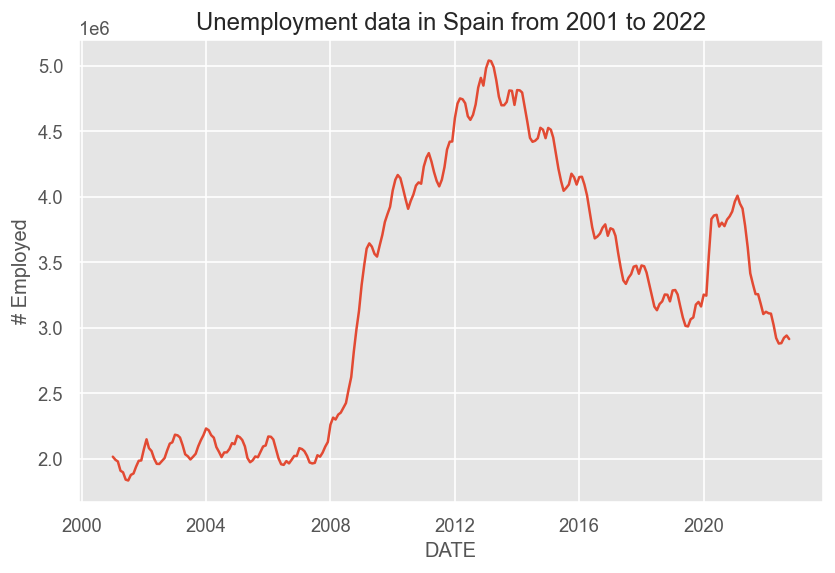

In [4]:
# Plotting a time series
fig, ax = plt.subplots()
ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from 2001 to 2022', xlabel='DATE', ylabel='# Employed')
plt.show()

## Seasonal ARIMA

Graficamos la serie temporal para saber si es estacionaria en media y varianza

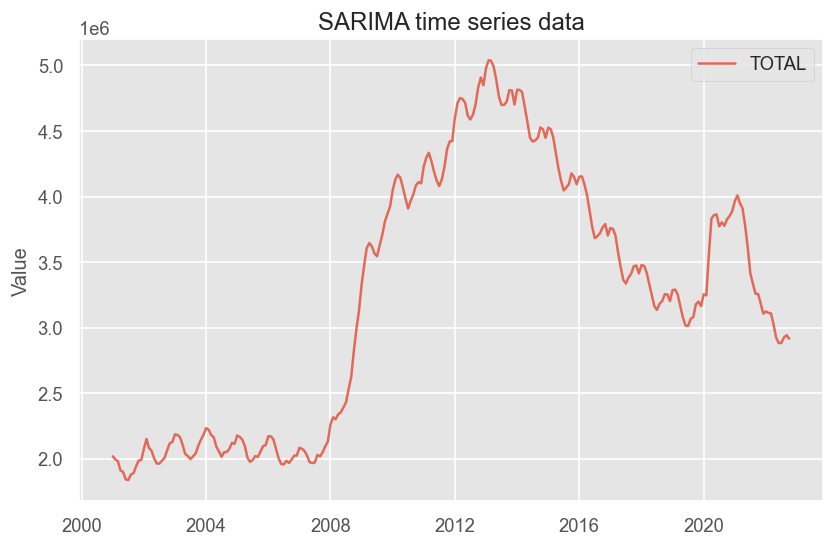

In [5]:
# Plotting a time series
fig, ax = plt.subplots()
for col in df.columns.values.tolist():
    ax.plot(col, data=df, label=col, alpha=0.8)
ax.set(title='SARIMA time series data', ylabel='Value')
plt.legend()
plt.show()

c:\Users\mipc\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



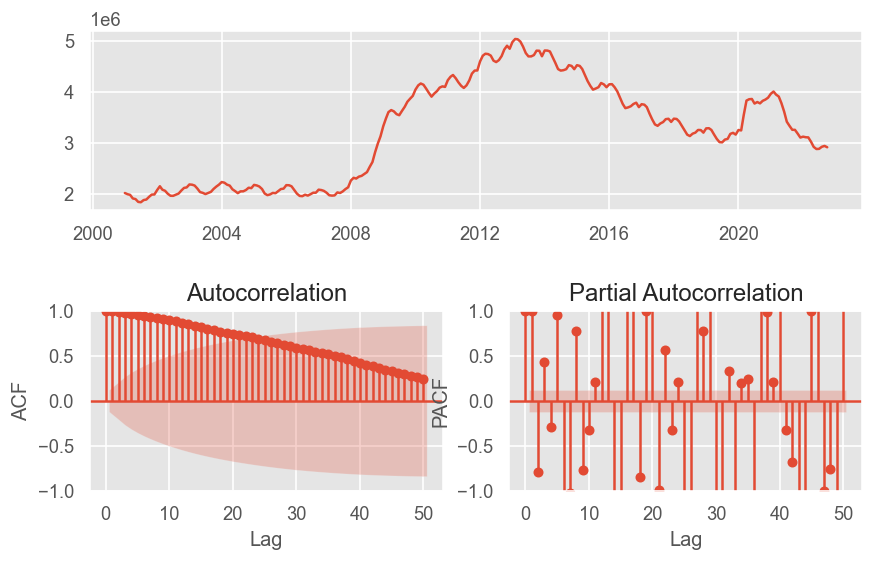

In [6]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df,lags=50)

In [7]:
df.reset_index(inplace=True)
df.head()

DATE    TOTAL
0 2001-01-01  2017389
1 2001-02-01  1993273
2 2001-03-01  1981006
3 2001-04-01  1910453
4 2001-05-01  1898285

In [8]:
df_ts = df[['TOTAL']] # Maintain data.frame format for column
df_ts

TOTAL
0    2017389
1    1993273
2    1981006
3    1910453
4    1898285
..       ...
257  2880582
258  2883812
259  2924240
260  2941919
261  2914892

[262 rows x 1 columns]

Diagnóstico a simple vista:

    * Podemos observar que la serie puede no ser estacionaria en media ya que hay dos tendecias claras a lo largo de la serie, primero desde 2008 hasta 2013, esto es debido a la crisis y por tanto la tasa de paró se disparó. Luego, una tendencia bajista desde 2013 hasta 2020, donde nos empezamos a recuperar de la crisis y por tanto, la tasa de paro bajo poco a poco.

    * Podemos observar que la serie no es estacionaria en varianza ya que el rango de valores de la variable y para los valores de x va cambiando con el tiempo

    * Podemos observar que durante los 8 primeros años parece haber una estacionalidad, hay un patrón que se repite cada año, esto puede ser debido a que normalmente la tasa de paro aumenta durante el invierno y decrece durante el verano.
    En los demás años también se pueden observar mínimos locales y máximos locales, esto seguramente es debido a algún tipo de estacionalidad, por ejemplo, es normal que la tasa de paro en navidad caiga ya que estamos en un periodo de alta demanda y muchos negocios requieren más personal y luego, la tasa de paro aumenta ya que esta demanda cae y no se necesita tanto personal.

Para comprobar lo anterior, primero representamos el gráfico de box-cox para saber si hay que realizar transformaciones para estabilizar la serie en varianza.

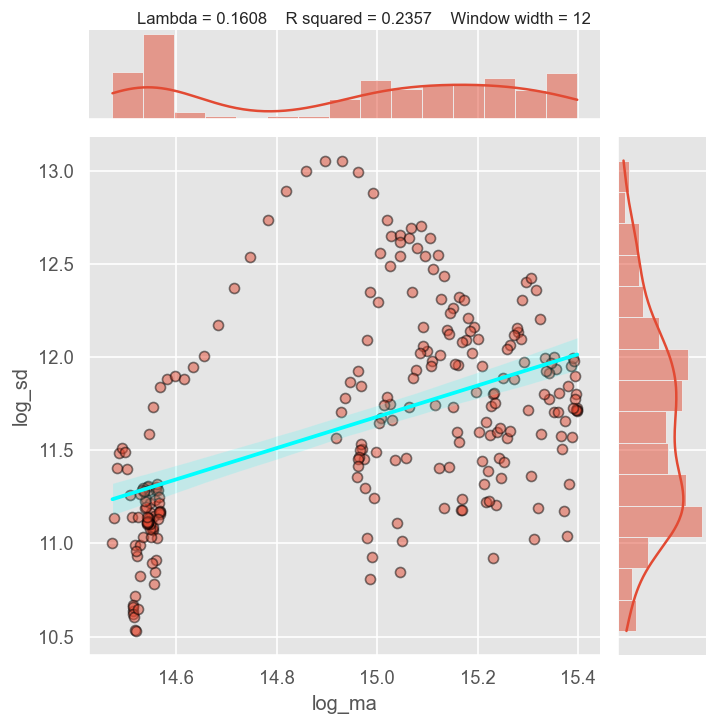

In [9]:
# Box-cox transformation
lmbda = FT.boxcox_lambda_plot(df_ts, window_width=12)

Podemos observar, el valor del logaritmo de la media móvil depende del valor del logaritmo de la desviación típica, por tanto, la serie NO es estacionaria en varianza.  
El valor necesario de lambda para la transformación es de 0.2721.

c:\Users\mipc\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



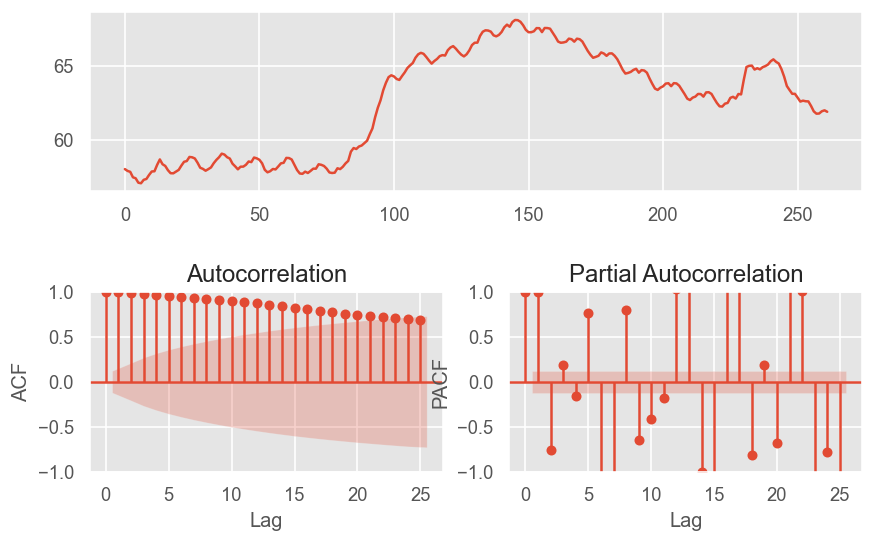

In [10]:
# Compute Box Cox
BOX_COX = True
if BOX_COX:
    lmbda = 0.1608
    z = st.boxcox(df_ts.values[:,0], lmbda = lmbda) #Convert to positive
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_ts.columns.values.tolist())
else:
    z = df_ts

FT.ts_display(z)

De primeras podemos observar que tiene buena pinta, pero volvemos a pintar el gráfico de box-cox para asegurarnos.

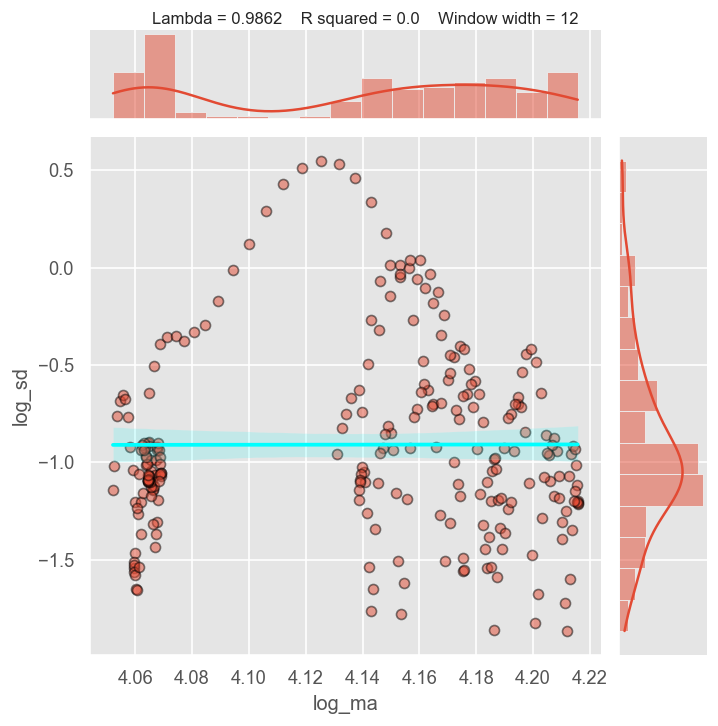

0.9861735104267518

In [11]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

c:\Users\mipc\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



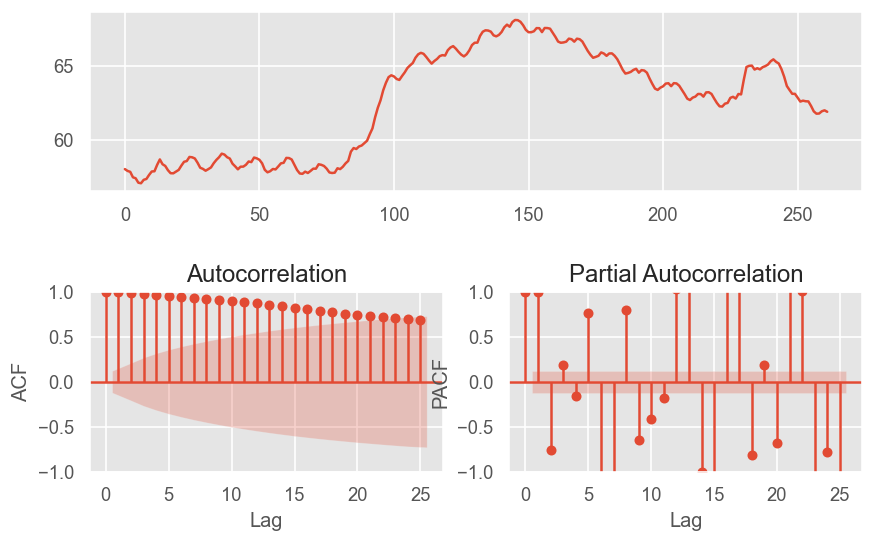

In [12]:
#Graphically
FT.ts_display(z)

Tras realizar la transformación Box-Cox el logaritmo de la media móvil ya no depende de los valores que toma el logaritmno de la desviación estándar, por tanto, la serie ya SÍ es estacionaria en varianza.

Para comprobar si la serie no es estacionaria en media, utilizamos el test de dickey fuller, este test nos dice si es o no necesario diferenciar regularmente.

In [13]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.644424
p-value: 0.459950
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


Podemos observar que el valor del p-valor es muchísimo más grande que 0.05, por tanto, se necesario diferenciar regularmente la serie ya que no es estacionaria en media.

c:\Users\mipc\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



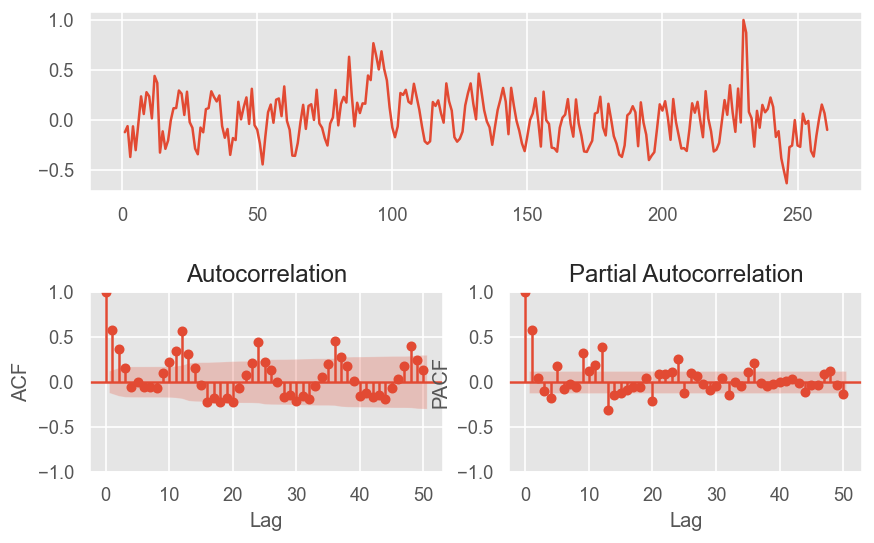

In [14]:
# Difference of the time series
d = 1

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
FT.ts_display(Bz,lags=50)

Tras diferenciar podemos observar que hay algo periódico en la serie (fijándonos en la autocorrelación simple), tenemos comportamiento estacional, por tanto, hay una tendencia estacional en la serie. Al tener una tendencia estacional en la serie, la serie no es estacionaria en la media ya que la ACF no decrece, por tanto, tenemos que diferenciar estacionalmente.  
Podemos observar que el patrón se repite cada más o menos 12 lags.

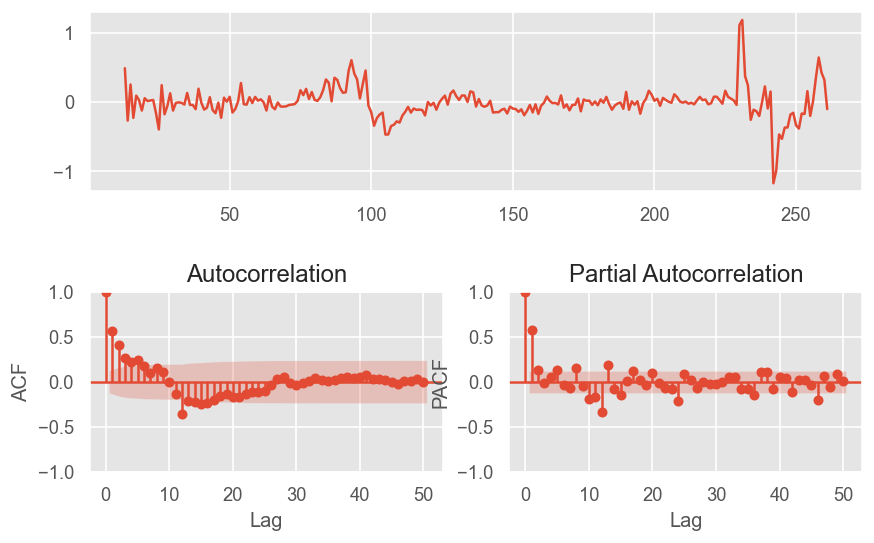

In [15]:
# Difference of the time series
d = 1 # diferenciación regular
D = 1 # diferenciación estacional
S = 12 # Seasonality of 12 days

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Vemos que ahora ya SÍ es estacionaria en la media

Para determinar los parámetros del modelo:  

    * Parte regular -> Nos fijamos en la parte regular (antes de que se repita) -> Primer periodo  
    * Para estacional -> Nos fijamos solo en los múltiplos del periodo -> (P,D,Q,S)

Vemos que para la parte regular tenemos dos posibles modelos -> AR(1) o MA(3), nos quedamos con el modelo más simple -> AR(1), por tanto, (1,1,0) -> (P,D,Q).  
Para la parte estacional tenemos otros dos posibles modelos, AR(1) o MA(1), nos quedamos con el modelo más simple, en este caso los dos son igual de simples, nos quedamos con MA(1) por tanto -> (0,1,1,12) -> (P,D,Q,S).

#### Fit SARIMA model and check significance of the coefficients

Aplicamos el modelo

In [16]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(1,1,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  262
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 129.159
Date:                              Thu, 01 Dec 2022   AIC                           -252.318
Time:                                      17:50:00   BIC                           -241.926
Sample:                                           0   HQIC                          -248.129
                                              - 262                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6787      0.028     23.951      0.000       0.623       0.734
ma.S.L12      -0.84

Si nos fijamos en los p-valores de las componentes del modelo, podemos observar como todas las componentes son significaticas

#### Analyze residuals

c:\Users\mipc\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  18.372306   0.826184


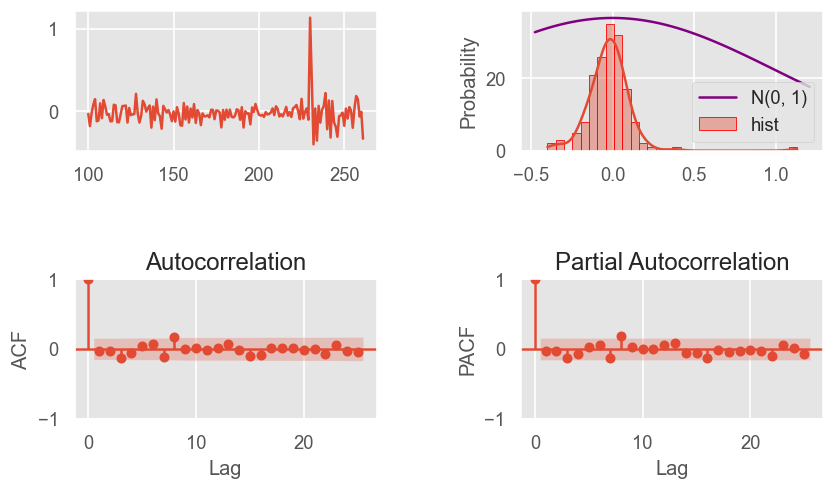

In [17]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

Analizando los residuos del modelo, podemos observar como son casi 0, y están bajo el umbral, por tanto, podemos concluir que los residuos aleatorios (ruido blanco)m, por tanto, no son predecibles, por consiguiente, el modelo elegido es correcto.

In [18]:
df_ts.shape[0]

262

#### Prediction

Establecemos realizar la predicción para 20 instantes más

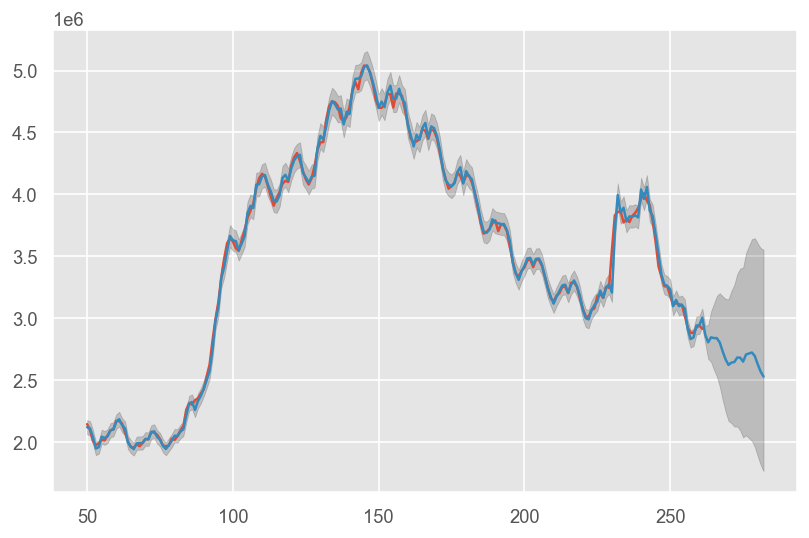

In [19]:
#Obtain forecasts for in-sample and out-of-sample
start = 50
horizon = 20 # que prediga 20 instantes más
end = df_ts.shape[0] + horizon

pred = sarima_fit.get_prediction(start=start, end= end, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_ts.loc[start:])
plt.plot(yhat)
plt.plot()
plt.show()

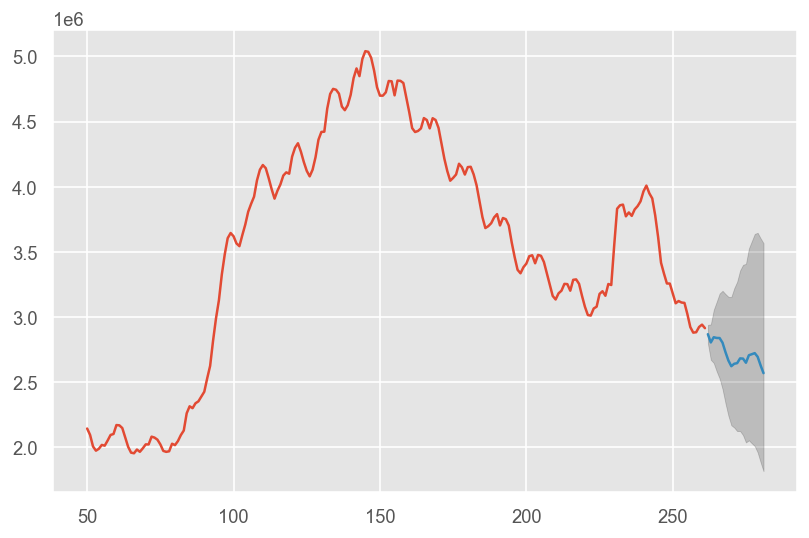

In [20]:
# Plot prediction of out_of_sample and confidence intervals
# If using dynamic = True, the forecast are used as real data
horizon = 20
end = df_ts.shape[0] + horizon

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_ts.loc[50:])
plt.plot(yhat)
plt.show()

## SARIMAX

Este tipo de modelos tienen en cuenta variables exógenas, es decir, tienen la capacidad de utilizar variables explicativas para realizar el forecast. Introducimos una variable al dataset que modele el COVID, por tanto, vamos a crear una variable que sea 0 en época de no covid y 1 en época covid.

In [21]:
df.head()

DATE    TOTAL
0 2001-01-01  2017389
1 2001-02-01  1993273
2 2001-03-01  1981006
3 2001-04-01  1910453
4 2001-05-01  1898285

Según los valores que toma la tasa de paro fijándonos en la gráfico de la serie temporal, establecemos que nuestra variable exógena que modela el comportamiento del paro en la etapa del COVID va a tomar valor 1 desde Marzo de 2020 hasta Agosto de 2021 (incluido).

In [22]:
df['COVID'] = np.where((df.DATE >= datetime.strptime('2020-03-01', '%Y-%m-%d')) & (df.DATE < datetime.strptime('2021-09-01', '%Y-%m-%d')), 1, 0)
df.loc[(df.DATE >= datetime.strptime('2020-01-03', '%Y-%m-%d')) & (df.DATE <= datetime.strptime('2021-09-01', '%Y-%m-%d'))]

DATE    TOTAL  COVID
229 2020-02-01  3246047      0
230 2020-03-01  3548312      1
231 2020-04-01  3831203      1
232 2020-05-01  3857776      1
233 2020-06-01  3862883      1
234 2020-07-01  3773034      1
235 2020-08-01  3802814      1
236 2020-09-01  3776485      1
237 2020-10-01  3826043      1
238 2020-11-01  3851312      1
239 2020-12-01  3888137      1
240 2021-01-01  3964353      1
241 2021-02-01  4008789      1
242 2021-03-01  3949640      1
243 2021-04-01  3910628      1
244 2021-05-01  3781250      1
245 2021-06-01  3614339      1
246 2021-07-01  3416498      1
247 2021-08-01  3333915      1
248 2021-09-01  3257802      0

Para realizar el modelo utilizamos los mismos parámetro utilizados en el Seasonal ARIMA incluyendo la variable exógena.

In [23]:
# Fit model with estimated order
INPUTS_SARIMAX = ['COVID']
sarimax_fit = SARIMAX(z, 
                    order=(1,1,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    exog = df[INPUTS_SARIMAX],
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarimax_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  262
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 138.161
Date:                              Thu, 01 Dec 2022   AIC                           -268.322
Time:                                      17:50:02   BIC                           -254.466
Sample:                                           0   HQIC                          -262.737
                                              - 262                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
COVID          0.3311      0.023     14.156      0.000       0.285       0.377
ar.L1          0.67

Si nos fijamos en los p-valores de las componentes del modelo, podemos observar como todas las componentes son significaticas

#### Analyze Residuals

c:\Users\mipc\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  26.478782   0.382414


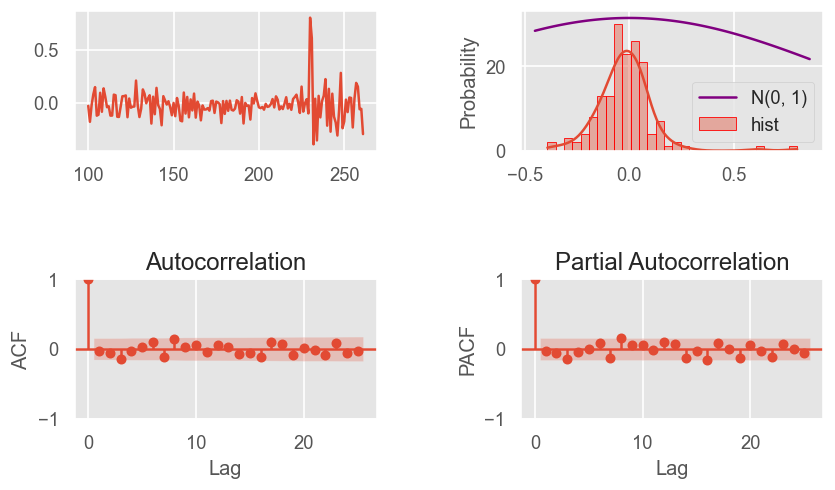

In [24]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarimax_fit.resid.loc[100:]))

Analizando los residuos del modelo, podemos observar como son casi 0, y están bajo el umbral, por tanto, podemos concluir que los residuos aleatorios (ruido blanco)m, por tanto, no son predecibles, por consiguiente, el modelo elegido es correcto.

#### Prediction

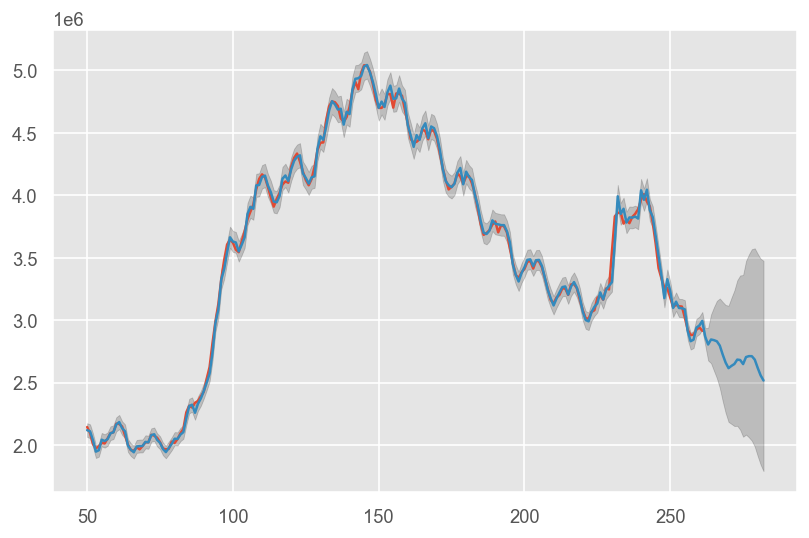

In [25]:
#Obtain forecasts for in-sample and out-of-sample
start = 50
horizon = 20 # que prediga 20 instantes más
end = df_ts.shape[0] + horizon

pred = sarimax_fit.get_prediction(start=start, end= end, exog = df['COVID'][0:21], dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_ts.loc[start:])
plt.plot(yhat)
plt.show()

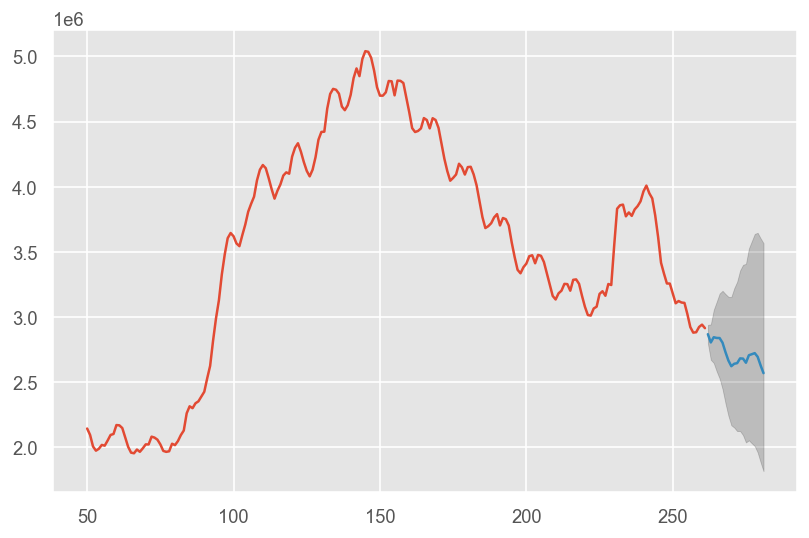

In [26]:
# Plot prediction of out_of_sample and confidence intervals
# If using dynamic = True, the forecast are used as real data
horizon = 20
end = df_ts.shape[0] + horizon

pred = sarima_fit.get_forecast(steps=horizon, exog = df['COVID'][0:21], dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_ts.loc[50:])
plt.plot(yhat)
plt.show()

## Non-Linearities

Incluimos una variable que modele la crisis económica del 2008. La crisis duró desde el 2008 hasta el 2014, por tanto, dicha variable tomará valor 1 en esos años y 0 en los demás años.

In [27]:
#df['CRISIS'] = np.where((df.DATE >= datetime.strptime('2008-01-01', '%Y-%m-%d')) & (df.DATE < datetime.strptime('2015-01-01', '%Y-%m-%d')), 1, 0)
#df.loc[(df.DATE >= datetime.strptime('2007-12-01', '%Y-%m-%d')) & (df.DATE <= datetime.strptime('2015-01-01', '%Y-%m-%d'))]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    262 non-null    datetime64[ns]
 1   TOTAL   262 non-null    int64         
 2   COVID   262 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(1)
memory usage: 5.2 KB


In [29]:
###Include lagged variables
dfT = df[['TOTAL']].copy()
dfT['TOTAL_lag1'] = dfT['TOTAL'].shift(1)
dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)
dfT['TOTAL_lag3'] = dfT['TOTAL'].shift(3)
dfT['TOTAL_lag4'] = dfT['TOTAL'].shift(4)
dfT['TOTAL_lag5'] = dfT['TOTAL'].shift(5)
dfT['TOTAL_lag6'] = dfT['TOTAL'].shift(6)

dfT.head()

TOTAL  TOTAL_lag1  TOTAL_lag2  TOTAL_lag3  TOTAL_lag4  TOTAL_lag5  \
0  2017389         NaN         NaN         NaN         NaN         NaN   
1  1993273   2017389.0         NaN         NaN         NaN         NaN   
2  1981006   1993273.0   2017389.0         NaN         NaN         NaN   
3  1910453   1981006.0   1993273.0   2017389.0         NaN         NaN   
4  1898285   1910453.0   1981006.0   1993273.0   2017389.0         NaN   

   TOTAL_lag6  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [30]:
# Remove missing
dfT.dropna(inplace=True)
dfT.head()

TOTAL  TOTAL_lag1  TOTAL_lag2  TOTAL_lag3  TOTAL_lag4  TOTAL_lag5  \
6   1835738   1842556.0   1898285.0   1910453.0   1981006.0   1993273.0   
7   1878513   1835738.0   1842556.0   1898285.0   1910453.0   1981006.0   
8   1889185   1878513.0   1835738.0   1842556.0   1898285.0   1910453.0   
9   1940910   1889185.0   1878513.0   1835738.0   1842556.0   1898285.0   
10  1985857   1940910.0   1889185.0   1878513.0   1835738.0   1842556.0   

    TOTAL_lag6  
6    2017389.0  
7    1993273.0  
8    1981006.0  
9    1910453.0  
10   1898285.0

In [31]:
dfT.columns

Index(['TOTAL', 'TOTAL_lag1', 'TOTAL_lag2', 'TOTAL_lag3', 'TOTAL_lag4',
       'TOTAL_lag5', 'TOTAL_lag6'],
      dtype='object')

In [32]:
# Define input and output matrices
INPUTS = ['TOTAL_lag1', 'TOTAL_lag2', 'TOTAL_lag3', 'TOTAL_lag4', 'TOTAL_lag5', 'TOTAL_lag6']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train = X.iloc[0:round(0.8*X.shape[0])]
X_test = X.iloc[round(0.8*X.shape[0])+1:X.shape[0]]
y_train = y.iloc[0:round(0.8*X.shape[0])]
y_test = y.iloc[round(0.8*X.shape[0])+1:X.shape[0]]


## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['TOTAL'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['TOTAL'] = y_test # We will call Y as output variable for simplicity


X_train.head()

TOTAL_lag1  TOTAL_lag2  TOTAL_lag3  TOTAL_lag4  TOTAL_lag5  TOTAL_lag6
6    1842556.0   1898285.0   1910453.0   1981006.0   1993273.0   2017389.0
7    1835738.0   1842556.0   1898285.0   1910453.0   1981006.0   1993273.0
8    1878513.0   1835738.0   1842556.0   1898285.0   1910453.0   1981006.0
9    1889185.0   1878513.0   1835738.0   1842556.0   1898285.0   1910453.0
10   1940910.0   1889185.0   1878513.0   1835738.0   1842556.0   1898285.0

In [33]:
#------------------------------- MLP Regression MODEL -------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP_NUM = ['TOTAL_lag1', 'TOTAL_lag2', 'TOTAL_lag3', 'TOTAL_lag4', 'TOTAL_lag5', 'TOTAL_lag6']
INPUTS_MLP_CAT = [] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.000001,0.00001,0.0001,0.001,0.01], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(10,),(13,),(20,),(25,),(30,),(35,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='relu', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid

c:\Users\mipc\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['TOTAL_lag1',
                                                                          'TOTAL_lag2',
                                                                          'TOTAL_lag3',
                                                                          'TOTAL_lag4',
                                                                          'TOTAL_lag5',
                                                                          'TOTAL_lag6']),
                                                                        ('cat',
                       

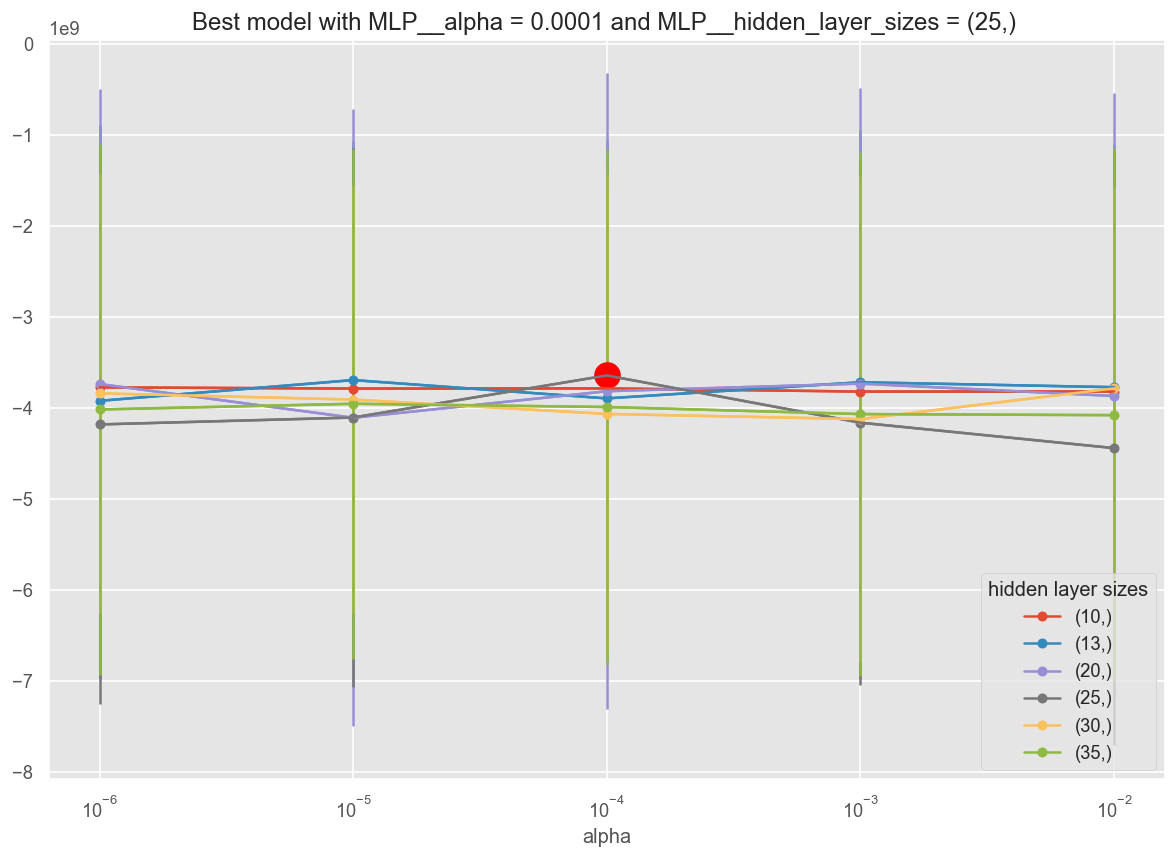

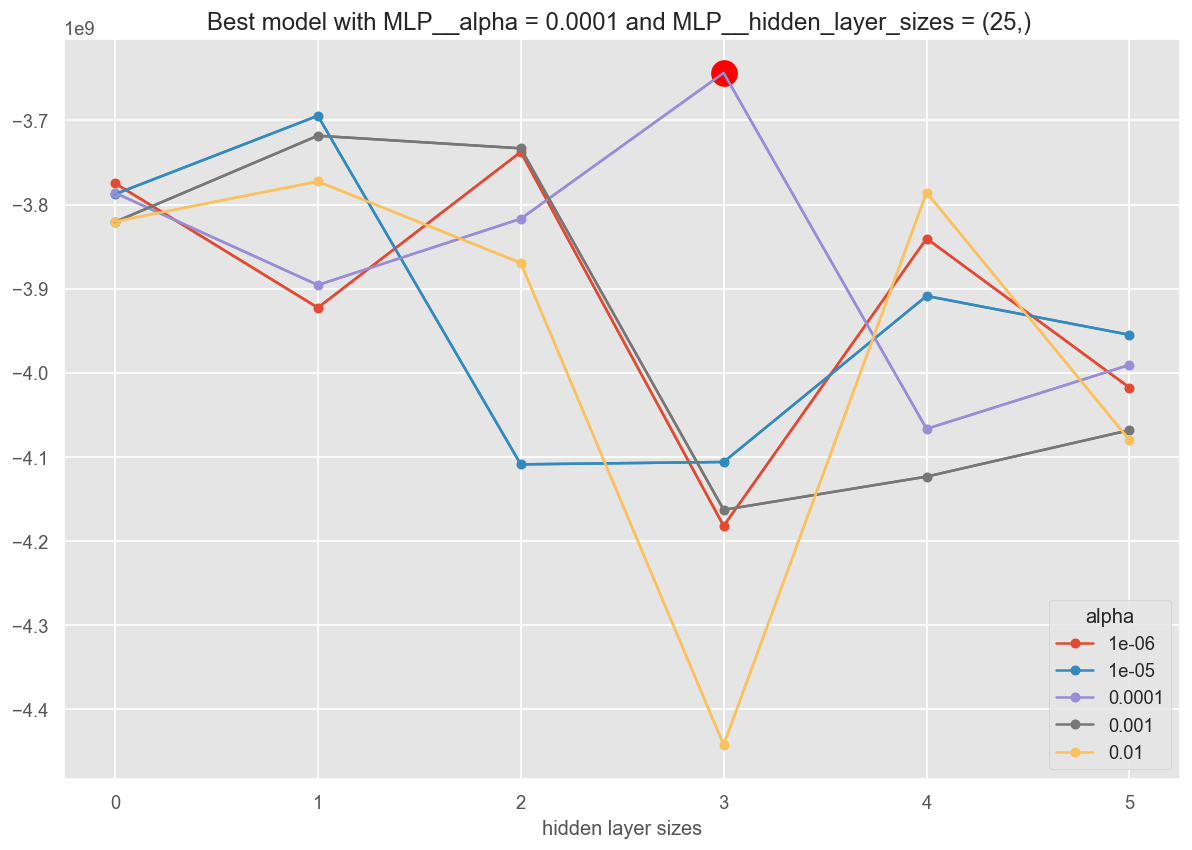

In [34]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(MLP_fit, xscale="log")

In [35]:
# SENSITIVITY ANALYSIS
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=['Y'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

#Compute sensitivities
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()
#sensmlp.info()

Sensitivity analysis of [6, 25, 1] MLP network.

Sensitivity measures of each output:

$Y 

                         mean            std  mean_squared
num__TOTAL_lag1  1.527593e+06  184806.068628  1.538731e+06
num__TOTAL_lag2 -4.201875e+05  263861.203457  4.961655e+05
num__TOTAL_lag3 -2.082491e+04   78029.176273  8.076032e+04
num__TOTAL_lag4 -3.434913e+05  203686.662207  3.993426e+05
num__TOTAL_lag5  3.057831e+05   92722.733185  3.195322e+05
num__TOTAL_lag6 -4.951179e+04   10827.266918  5.068182e+04


c:\Users\mipc\anaconda3\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



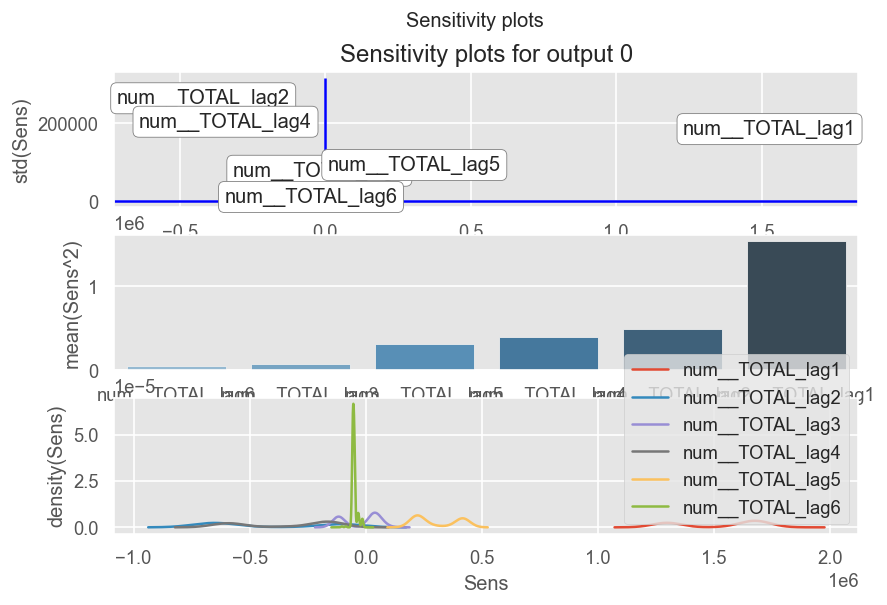

In [36]:
sensmlp.plot()

In [37]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))

Training MAE: 35801.10339752176
Test MAE: 61201.93362511665
Training RMSE: 48982.59834369972
Test RMSE: 79512.86705083633
Training R2: 0.9979271715148472
Test R2: 0.9479996991186874


In [38]:
dfTR_eval.head()

TOTAL_lag1  TOTAL_lag2  TOTAL_lag3  TOTAL_lag4  TOTAL_lag5  TOTAL_lag6  \
6    1842556.0   1898285.0   1910453.0   1981006.0   1993273.0   2017389.0   
7    1835738.0   1842556.0   1898285.0   1910453.0   1981006.0   1993273.0   
8    1878513.0   1835738.0   1842556.0   1898285.0   1910453.0   1981006.0   
9    1889185.0   1878513.0   1835738.0   1842556.0   1898285.0   1910453.0   
10   1940910.0   1889185.0   1878513.0   1835738.0   1842556.0   1898285.0   

      TOTAL      MLP_pred  
6   1835738  1.851764e+06  
7   1878513  1.884800e+06  
8   1889185  1.923045e+06  
9   1940910  1.961236e+06  
10  1985857  2.000775e+06

In [39]:
dfTS_eval.head()

TOTAL_lag1  TOTAL_lag2  TOTAL_lag3  TOTAL_lag4  TOTAL_lag5  TOTAL_lag6  \
212   3182068.0   3135021.0   3162162.0   3252130.0   3335868.0   3422551.0   
213   3202509.0   3182068.0   3135021.0   3162162.0   3252130.0   3335868.0   
214   3254703.0   3202509.0   3182068.0   3135021.0   3162162.0   3252130.0   
215   3252867.0   3254703.0   3202509.0   3182068.0   3135021.0   3162162.0   
216   3202297.0   3252867.0   3254703.0   3202509.0   3182068.0   3135021.0   

       TOTAL      MLP_pred  
212  3202509  3.210984e+06  
213  3254703  3.236116e+06  
214  3252867  3.297682e+06  
215  3202297  3.252537e+06  
216  3285761  3.182001e+06

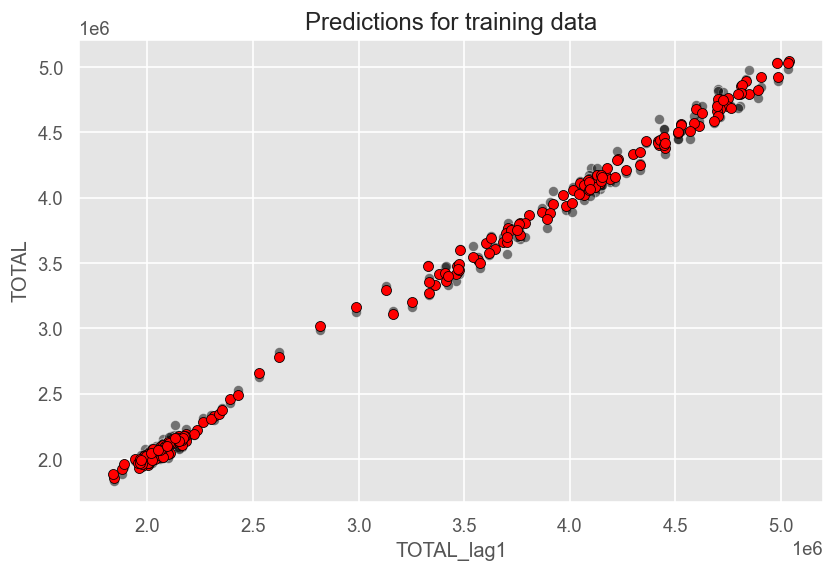

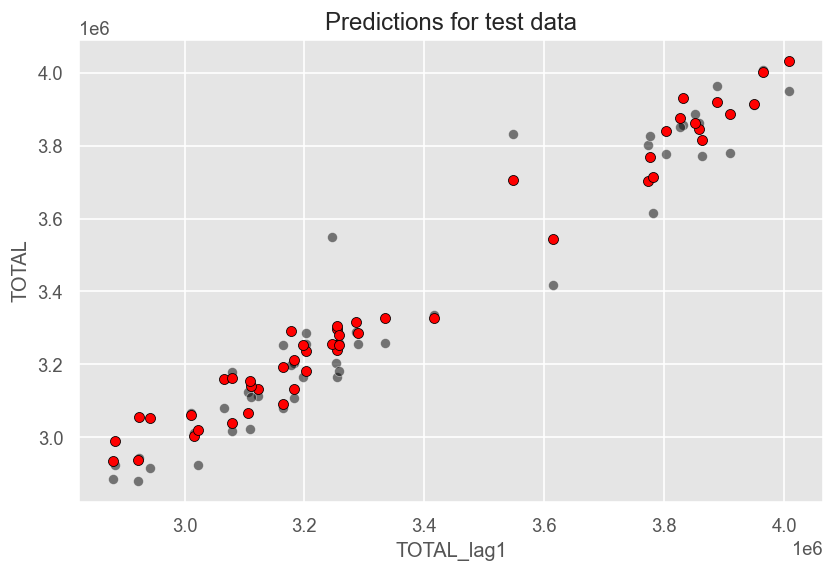

In [40]:
### Plot predictions of the model
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for test data')
plt.show()

In [41]:
dfTR_eval.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 6 to 210
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TOTAL_lag1  205 non-null    float64
 1   TOTAL_lag2  205 non-null    float64
 2   TOTAL_lag3  205 non-null    float64
 3   TOTAL_lag4  205 non-null    float64
 4   TOTAL_lag5  205 non-null    float64
 5   TOTAL_lag6  205 non-null    float64
 6   TOTAL       205 non-null    int64  
 7   MLP_pred    205 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 14.4 KB


In [42]:
np.isfinite(dfTR_eval).sum()

TOTAL_lag1    205
TOTAL_lag2    205
TOTAL_lag3    205
TOTAL_lag4    205
TOTAL_lag5    205
TOTAL_lag6    205
TOTAL         205
MLP_pred      205
dtype: int64

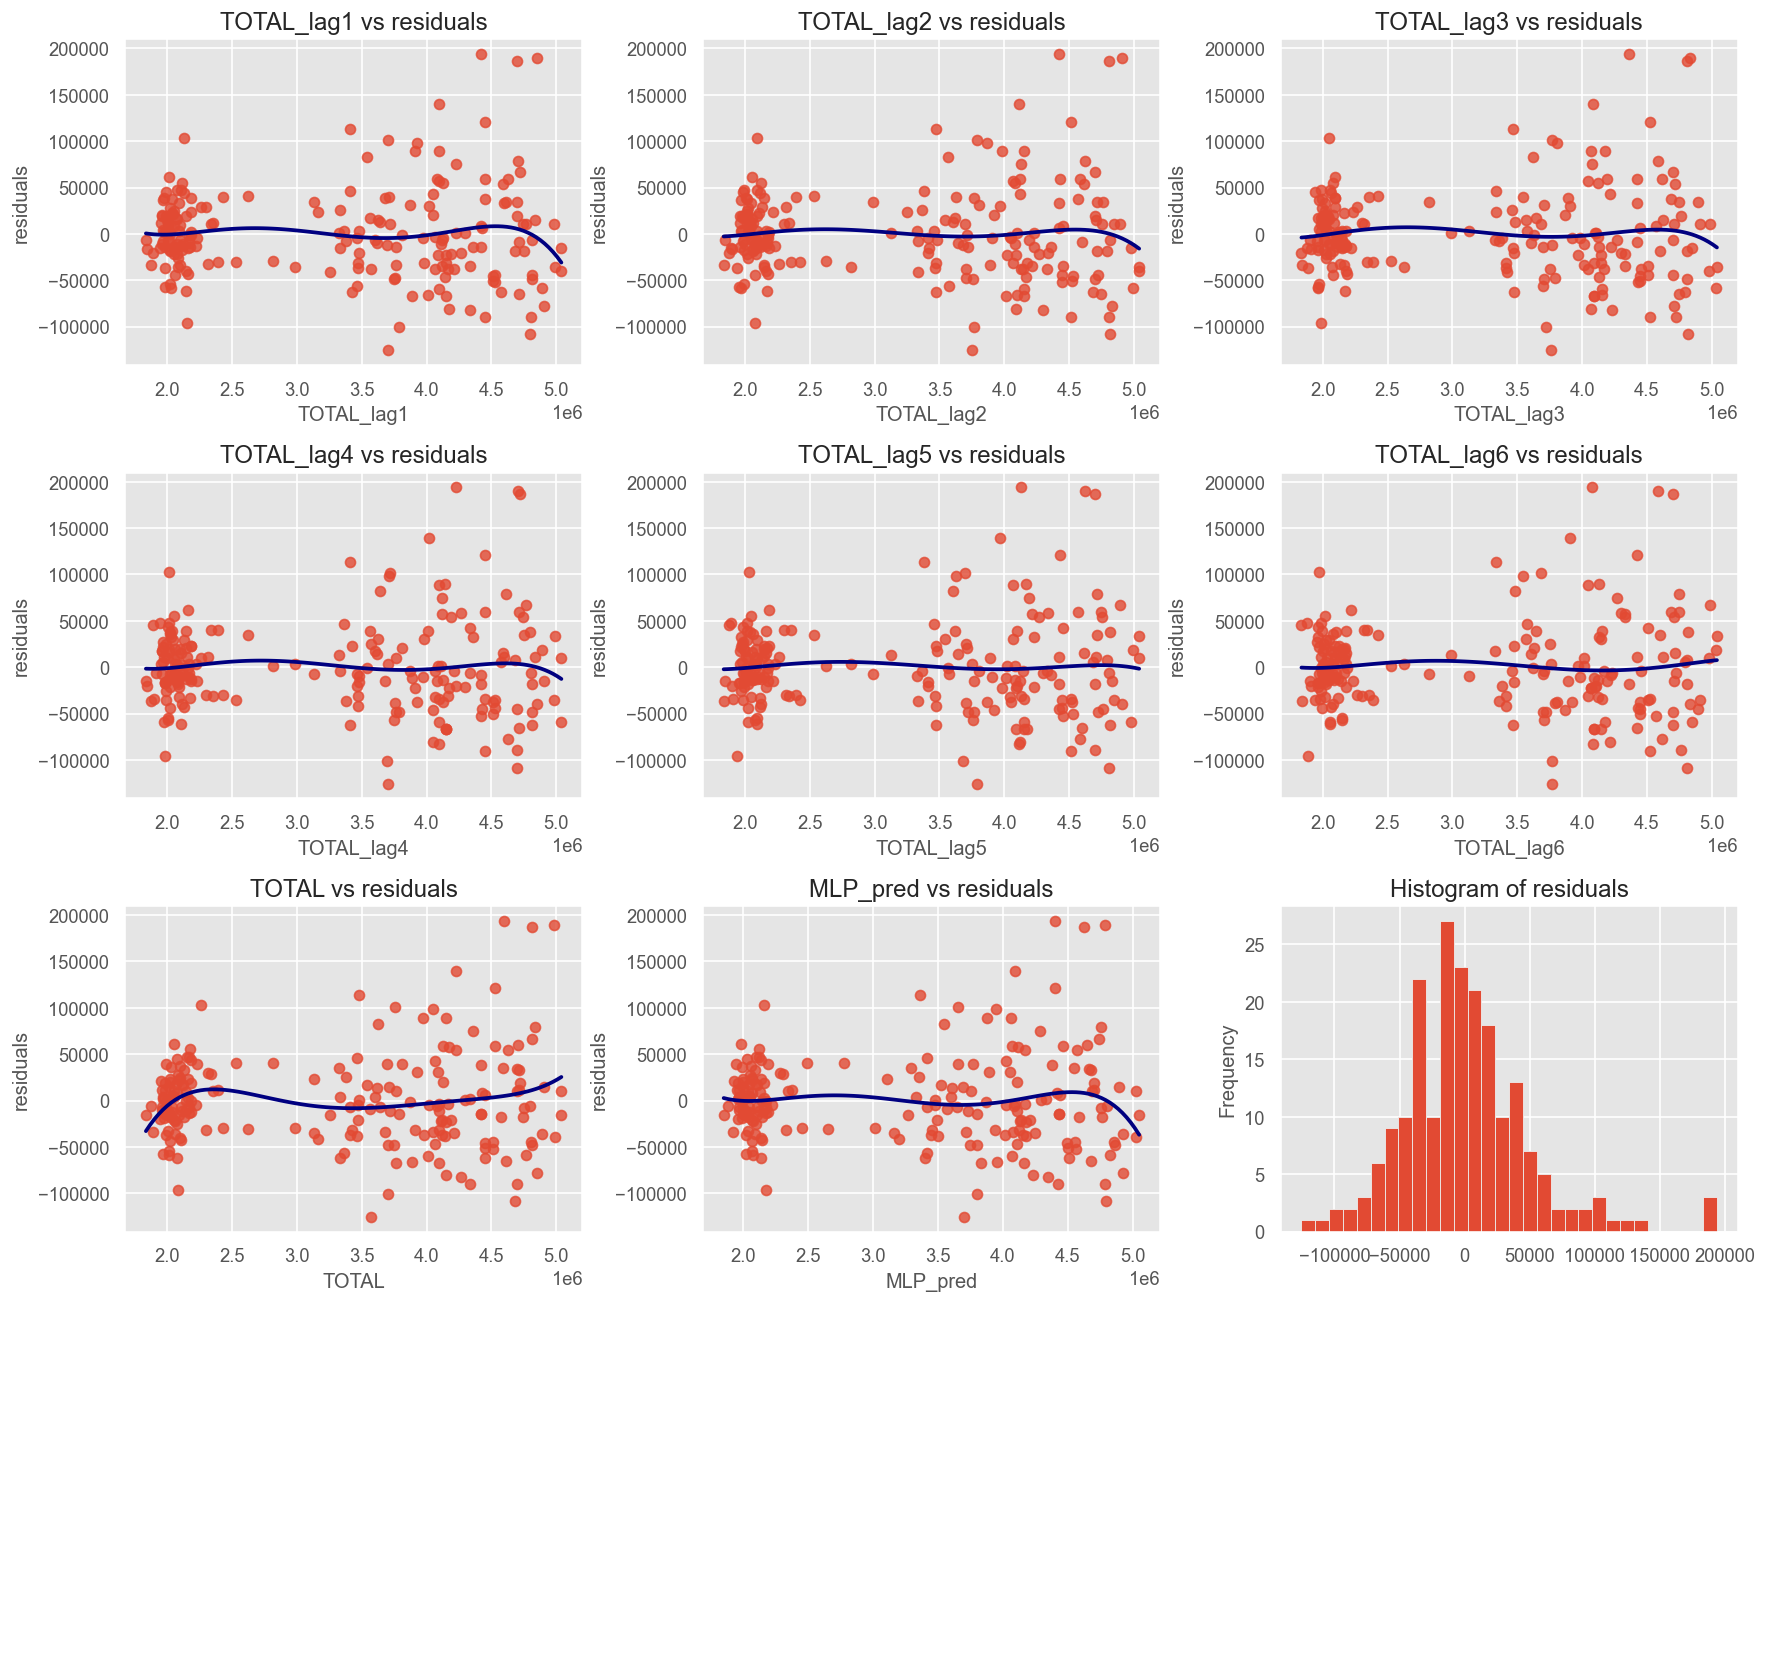

In [43]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'MLP_pred', 'TOTAL',figsize=[15,15])

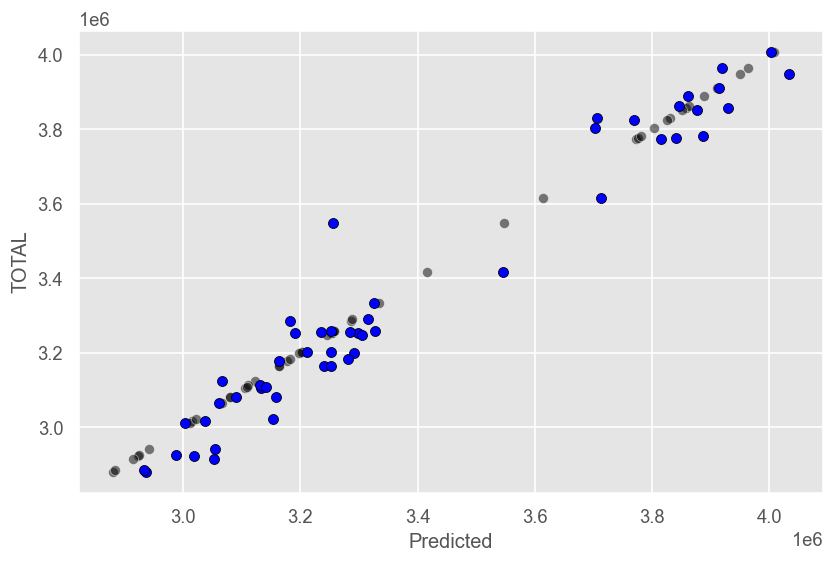

In [44]:
# Visualize prediction with respect to output
sns.scatterplot(data=dfTS_eval, x='TOTAL', y='TOTAL', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='MLP_pred', y='TOTAL', color='blue', edgecolor='black')
plt.xlabel('Predicted')
plt.show()

c:\Users\mipc\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



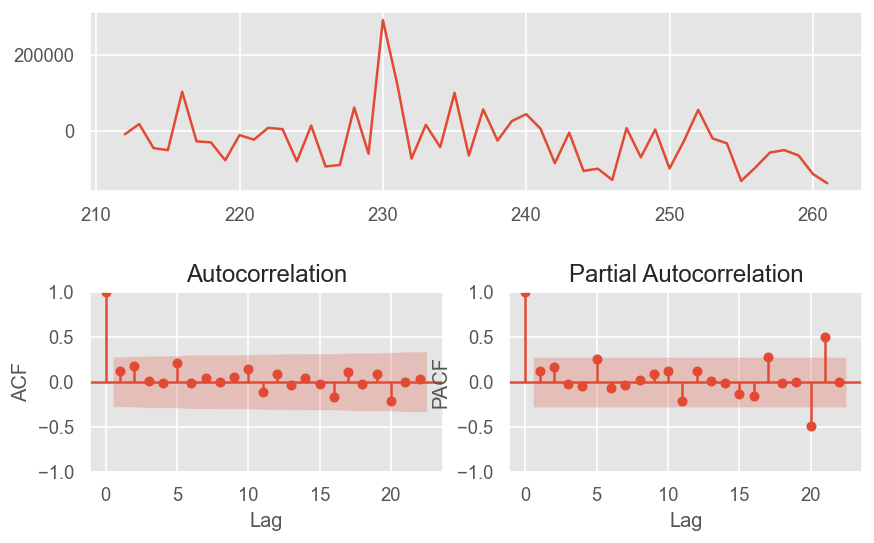

In [45]:
# Check correlation of residuals
FT.ts_display(dfTS_eval['TOTAL'] - dfTS_eval['MLP_pred'], lags=22)

## FORECAST November 2022

### SARIMAX 

Utilizamos las variables crisis y covid que hemos creado antes.

In [46]:
df.head()

DATE    TOTAL  COVID
0 2001-01-01  2017389      0
1 2001-02-01  1993273      0
2 2001-03-01  1981006      0
3 2001-04-01  1910453      0
4 2001-05-01  1898285      0

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    262 non-null    datetime64[ns]
 1   TOTAL   262 non-null    int64         
 2   COVID   262 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(1)
memory usage: 5.2 KB


Utilizamos SARIMAX

In [48]:
# Fit model with estimated order
INPUTS_SARIMAX = ['COVID']
sarimax_fit = SARIMAX(z, 
                    order=(1,1,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    exog = df[INPUTS_SARIMAX],
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarimax_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  262
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 138.161
Date:                              Thu, 01 Dec 2022   AIC                           -268.322
Time:                                      17:51:34   BIC                           -254.466
Sample:                                           0   HQIC                          -262.737
                                              - 262                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
COVID          0.3311      0.023     14.156      0.000       0.285       0.377
ar.L1          0.67

c:\Users\mipc\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  26.478782   0.382414


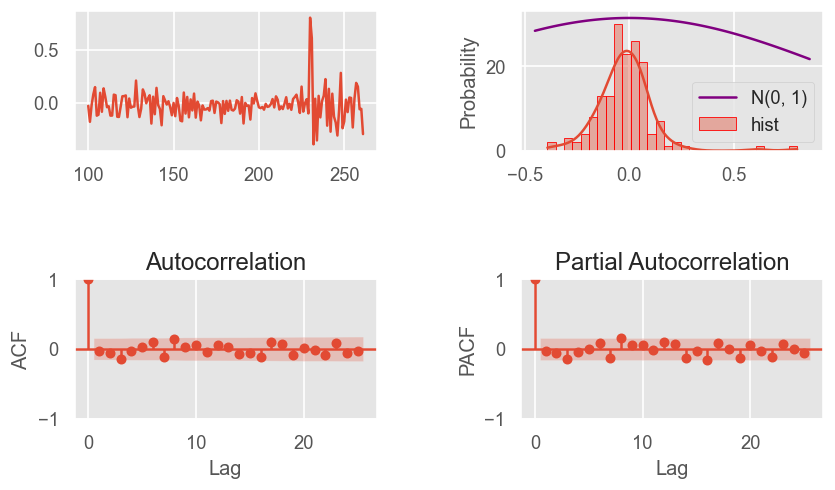

In [49]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarimax_fit.resid.loc[100:]))

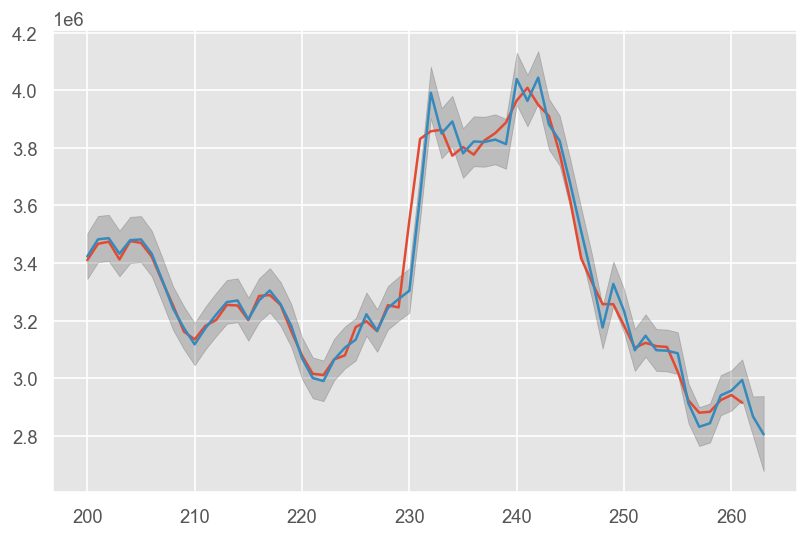

In [50]:
#Obtain forecasts for in-sample and out-of-sample
start = 200
horizon = 1 # que prediga 1 instantes más
end = df_ts.shape[0] + horizon

pred = sarimax_fit.get_prediction(start=start, end= end, exog = df[INPUTS_SARIMAX][0:2], dynamic=False)
yhat = pred.predicted_mean # valor de la predicción de Noviembre de 2022
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_ts.loc[start:])
plt.plot(yhat)
plt.show()

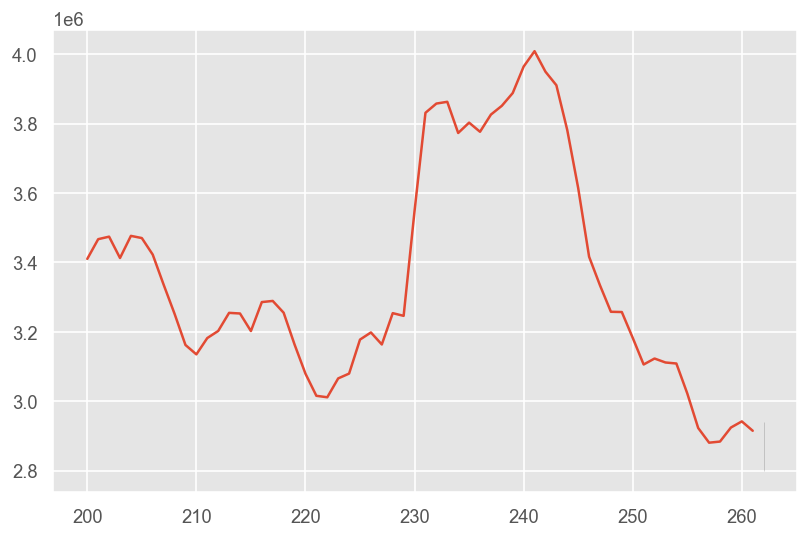

In [51]:
# Plot prediction of out_of_sample and confidence intervals
# If using dynamic = True, the forecast are used as real data
horizon = 1
end = df_ts.shape[0] + horizon

pred = sarima_fit.get_forecast(steps=horizon, exog = df[INPUTS_SARIMAX][0:21], dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_ts.loc[start:])
plt.plot(yhat)
plt.show()

In [52]:
prediccion_sarimax = round(yhat.values[0])
print('Predicción de la tasa de paro de noviembre de 2022 con SARIMAX es:', prediccion_sarimax)

Predicción de la tasa de paro de noviembre de 2022 con SARIMAX es: 2868528


### Prophet

Utilizamos prophet para realizar la predicción del mes de Noviembre de 2022. Al realizar este modelo tenemos en cuenta la época previa y posterior al covid y a la crisis de 2008.

In [53]:
# Import data
df = pd.read_csv('UnemploymentSpain.dat', parse_dates=['DATE'], dayfirst=True, sep='\t', index_col='DATE')
df.head()

TOTAL
DATE               
2001-01-01  2017389
2001-02-01  1993273
2001-03-01  1981006
2001-04-01  1910453
2001-05-01  1898285

In [54]:
df.reset_index(inplace=True)
df.head()

DATE    TOTAL
0 2001-01-01  2017389
1 2001-02-01  1993273
2 2001-03-01  1981006
3 2001-04-01  1910453
4 2001-05-01  1898285

In [55]:
df = df.rename(columns={'DATE': 'ds',
                        'TOTAL': 'y'})
df.head()

ds        y
0 2001-01-01  2017389
1 2001-02-01  1993273
2 2001-03-01  1981006
3 2001-04-01  1910453
4 2001-05-01  1898285

In [58]:
# Create new dates with monthly ('MS') frequency. Take this into account when using data with a different frequency.
# In this case, we want 1 new month
n_months = 1
future_dates = prophet_fit.make_future_dataframe(periods=n_months, freq='MS')
future_dates.tail()

NameError: name 'prophet_fit' is not defined

In [59]:
df2 = df.copy()
df2['pre_covid'] = pd.to_datetime(df2['ds']) < pd.to_datetime('2020-03-01')
df2['post_covid'] = ~df2['pre_covid']
df2['pre_crisis'] = pd.to_datetime(df2['ds']) < pd.to_datetime('2008-01-01')
df2['post_crisis'] = ~df2['pre_covid']

Incluimos las épocas de confinamiento como vacaciones

In [60]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

holiday         ds  lower_window   ds_upper  upper_window
0  lockdown_1 2020-03-21             0 2020-06-06            77
1  lockdown_2 2020-07-09             0 2020-10-27           110
2  lockdown_3 2021-02-13             0 2021-02-17             4
3  lockdown_4 2021-05-28             0 2021-06-10            13

In [61]:
prophet_model = Prophet(holidays=lockdowns, weekly_seasonality=False)
prophet_model.add_seasonality(
    name='weekly_pre_covid',
    period=1,
    fourier_order=3,
    condition_name='pre_covid',
)
prophet_model.add_seasonality(
    name='weekly_post_covid',
    period=1,
    fourier_order=3,
    condition_name='post_covid',
)
prophet_model.add_seasonality(
    name='weekly_pre_crisis',
    period=1,
    fourier_order=3,
    condition_name='pre_crisis',
)
prophet_model.add_seasonality(
    name='weekly_post_crisis',
    period=1,
    fourier_order=3,
    condition_name='post_crisis',
)
prophet_model = prophet_model.fit(df2)

17:58:48 - cmdstanpy - INFO - Chain [1] start processing
17:58:48 - cmdstanpy - INFO - Chain [1] done processing


Creamos las flags: pre_covid, post_covid, pre_crisis y post_crisis.

In [62]:
future['pre_covid'] = pd.to_datetime(future['ds']) < pd.to_datetime('2020-03-01')
future['post_covid'] = ~future['pre_covid']
future['pre_crisis'] = pd.to_datetime(future['ds']) < pd.to_datetime('2008-01-01')
future['post_crisis'] = ~future['pre_crisis']

NameError: name 'future' is not defined

Predecimos

In [ ]:
forecast = prophet_model.predict(future)
prophet_model.plot(forecast)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays + Conditional weekly seasonality')

In [ ]:
forecast.head()

In [ ]:
forecast.columns

In [ ]:
prediccion_prophet = round(forecast.loc[forecast['ds']=='2022-11-01']['yhat'].values[0])
print('Predicción de la tasa de paro de noviembre de 2022 con Prophet es:', prediccion_prophet)